In [14]:
# Graeme code

from PIL import Image, ImageEnhance
from skimage import io, data, transform, filters, color
import numpy
import math

# Sets plugin for skimage, using PIL to keep read in image formats the same for arrays
io.use_plugin('pil')

imagepath = "C:\\Users\\Graeme\\Desktop\\image5.jpg"

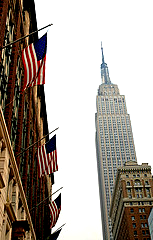

In [3]:
# Change contrast, that eventually can return the negative at high enough values
def change_contrast(img, level):
    factor = (259 * (level + 255)) / (255 * (259 - level))
    def contrast(c):
        value = 128 + factor * (c - 128)
        return max(0, min(255, value))
    return img.point(contrast)

change_contrast(Image.open(imagepath), 60)

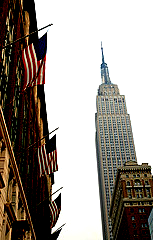

In [4]:
# Range is real numbers greater than 0 to infinity
def change_contrast_alt(img, level):
    contrast = ImageEnhance.Contrast(img)
    return contrast.enhance(level)

change_contrast_alt(Image.open(imagepath), 2)

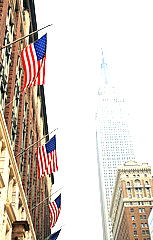

In [5]:
# Range is real numbers greater than 0 to infinity
def change_brightness(img, level):
    brightness = ImageEnhance.Brightness(img)
    return brightness.enhance(level)

change_brightness(Image.open(imagepath), 2)

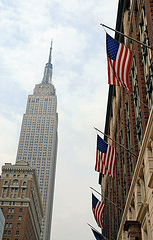

In [6]:
# Flip image over the vertical axis
def flip_vertical(img):
    return img.transpose(Image.FLIP_LEFT_RIGHT)

flip_vertical(Image.open(imagepath))   

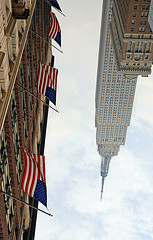

In [7]:
# Flip image over the horizontal axis
def flip_horizontal(img):
    return img.transpose(Image.FLIP_TOP_BOTTOM)

flip_horizontal(Image.open(imagepath))

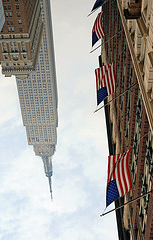

In [8]:
# Flip image over both axis
def flip_diagonal(img):
    imgcpy = img.transpose(Image.FLIP_TOP_BOTTOM)
    return imgcpy.transpose(Image.FLIP_LEFT_RIGHT)

flip_diagonal(Image.open(imagepath))

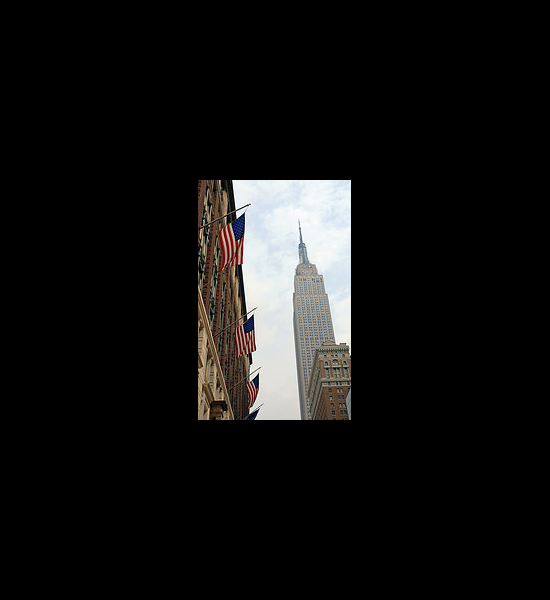

In [9]:
# By passing a new_size we have to consider that it may be under, which we technically don't want as we would just be
# creating copies of the image based on the code below
# Need to consider checking for size before this function if we choose to randomize the values
def pad_image(img, new_size):

    old_img = img
    old_size = old_img.size
    
    # Check that all dimensions are greater or equal so it doesn't crop
    if all(i >= j for i, j in zip(new_size, old_size)):
        new_img = Image.new("RGB", new_size)   ## luckily, this is already black!
        new_img.paste(old_img, (int((new_size[0]-old_size[0])/2), int((new_size[1]-old_size[1])/2)))
        return new_img
    else:
        return old_img
    
pad_image(Image.open(imagepath), (550, 600))

In [10]:
# Is bad, going to use the one below
def shear_image(imagepath, amount):
    # Load the image as a matrix
    img = io.imread(imagepath, plugin='pil')
    
    # read rad angle
    # determine pixel side length opposite angle
    # pad image width by above length
    
    # Create Affine transform
    affine_tf = transform.AffineTransform(shear=amount)
    # Apply transform
    return transform.warp(img, affine_tf)

img = shear_image(imagepath, 0.3)
io.show()

In [11]:
def find_coeffs(pa, pb):
    matrix = []
    for p1, p2 in zip(pa, pb):
        matrix.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1]])
        matrix.append([0, 0, 0, p1[0], p1[1], 1, -p2[1]*p1[0], -p2[1]*p1[1]])

    A = numpy.matrix(matrix, dtype=numpy.float)
    B = numpy.array(pb).reshape(8)

    res = numpy.dot(numpy.linalg.inv(A.T * A) * A.T, B)
    return numpy.array(res).reshape(8)

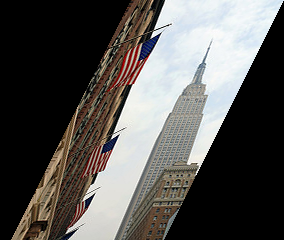

In [12]:
def skew_image(imagepath, angle):
    img = Image.open(imagepath)
    width, height = img.size
    
    # Get the width that is to be added to the image based on the angle of skew
    xshift = math.tan(abs(angle)) * height
    new_width = width + int((xshift))
    
    # Apply transform
    img = img.transform((new_width, height), Image.AFFINE,
            (1, angle, -xshift if angle > 0 else 0, 0, 1, 0), Image.BICUBIC)
    return img

skew_image(imagepath, 0.5)

In [13]:
def seam_carve_image(imagepath):
    # Load the image as a matrix
    img = io.imread(imagepath, plugin='pil')
    
    # Energy Map, used to determine which pixels will be removed
    eimg = filters.sobel(color.rgb2gray(img))
    
    # (Width, Height)
    img_Dimensions = img.shape
    
    # Squish width if width >= height, squish height if height > width
    if(img_Dimensions[0] >= img_Dimensions[1]):
        mode = 'vertical'
    else:
        mode = 'horizontal'
    
    # Number of seams to be removed, need to determine best way to randomize
    num_seams = 15
    
    # Number of pixels to keep along the outer edges
    border = 5
    
    return transform.seam_carve(img, eimg, mode, num_seams)

img = seam_carve_image(imagepath)
io.imsave('new.jpg', img)

C:\ProgramData\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
